In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gpra_dna_exp' in c['name'] 
    and 'loss' in c['config']
]   



In [4]:
cfgs[1]

{'name': 'gpra_dna_exp_114a02dfe55efe58ac7a69f224288178',
 'dir': '../outputs/gpra_dna_exp_114a02dfe55efe58ac7a69f224288178',
 'config': {'dataset': {'_target_': 'datasets.gpra_dna_dataset.GPRADNADataset', 'data_dir': '/orcd/scratch/bcs/001/njwfish/data/gpra_by_quantile', 'set_size': '${experiment.set_size}', 'num_quantiles': 100, 'window_width': 3, 'max_seq_length': 129, 'encoder_tokenizer': 'dna', 'hyena_tokenizer': 'char', 'num_sets': None, 'seed': '${seed}'}, 'encoder': {'_target_': 'encoder.dna_conv_encoder.DNAConvEncoder', 'in_channels': 5, 'hidden_channels': 64, 'out_channels': 128, 'hidden_dim': 256, 'latent_dim': '${experiment.latent_dim}', 'num_layers': 3, 'kernel_size': 7, 'seq_length': '${dataset.max_seq_length}', 'pool_type': 'mean', 'agg_type': 'mean'}, 'model': {'_target_': 'types.NoneType'}, 'generator': {'_target_': 'generator.hyenadna_generator.HyenaDNAGenerator', 'latent_dim': '${experiment.latent_dim}', 'condition_dim': 128, 'd_model': 128, 'n_layer': 6, 'max_seq_le

In [5]:
import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/best_model.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

enc, gen = instantiate_and_load_model(cfgs[1])

In [6]:
dataset = hydra.utils.instantiate(cfgs[1]['config'].dataset)

In [7]:
import os
import numpy as np

BASES = ["A", "C", "G", "T"]
BASE_TO_IDX = {b: i for i, b in enumerate(BASES)}

def load_pwm_file(path):
    pwm = np.zeros((4, 0))
    rows = {}
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if parts and parts[0] in BASE_TO_IDX:
                base = parts[0]
                rows[base] = list(map(float, parts[1:]))
    if set(rows.keys()) != set(BASES):
        raise ValueError(f"Incomplete base rows in {path}")
    pwm = np.array([rows[b] for b in BASES])  # A,C,G,T order
    return pwm

def load_pwms_from_dir(pwm_dir):
    motifs = []
    names = []
    for fname in os.listdir(pwm_dir):
        if fname.endswith(".pwm"):
            pwm = load_pwm_file(os.path.join(pwm_dir, fname))
            motifs.append(pwm)
            names.append(fname.replace(".pwm", ""))
    max_L = max(p.shape[1] for p in motifs)
    n = len(motifs)
    pwm_arr = np.full((n, 4, max_L), -800.0, dtype=np.float32)
    for i, p in enumerate(motifs):
        pwm_arr[i, :, :p.shape[1]] = p
    return pwm_arr, names  # shape: (n_motifs, 4, L_max)

pwm_arr, names = load_pwms_from_dir('../data/gpra/pwms')
pwm_arr = torch.from_numpy(pwm_arr)


In [8]:
def torch_batch_scan(onehot, pwms):
    n_seq, L_seq, _ = onehot.shape
    n_pwm, _, L_pwm = pwms.shape

    # Sliding window: (n_seq, L_seq, 4) → (n_seq, n_pos, L_pwm, 4)
    windows = onehot.unfold(dimension=1, size=L_pwm, step=1)  # shape: (n_seq, n_pos, L_pwm, 4)
    valid = (windows.sum(dim=2) == 1.0).all(dim=2)

    # Dot product: (n_seq, n_pos, 4, L) · (n_pwm, 4, L) → (n_seq, n_pos, n_pwm)
    scores = torch.einsum('spkl,mkl->spm', windows, pwms)

    return scores, valid  # shape: (n_seq, n_pos, n_pwm)

In [9]:
# scores_torch = torch_batch_scan(seqs[0], torch.from_numpy(pwm_arr))

In [10]:
cond = 'GSE104878_20161024_average_promoter_ELs_per_seq_3p1E7_Gal_ALL'
oh_seqs = {k: torch.from_numpy(np.vstack([batch['tokenized']['encoder_inputs'][..., :4] for batch in dataset.data_by_condition[cond][k]])) for k in dataset.data_by_condition[cond]}

In [11]:
enc_seqs = {k: torch.from_numpy(np.vstack([batch['tokenized']['encoder_inputs'] for batch in dataset.data_by_condition[cond][k]])) for k in dataset.data_by_condition[cond]}

In [12]:
enc.to('cuda')
gen.model.to('cuda')

ConditionedHyenaDNA(
  (model): HyenaDNAModel(
    (backbone): LMBackbone(
      (embeddings): GPT2Embeddings(
        (word_embeddings): Embedding(10, 128)
        (position_embeddings): Embedding(130, 128)
      )
      (layers): ModuleList(
        (0): Block(
          (mixer): HyenaOperator(
            (dropout): Dropout(p=0.0, inplace=False)
            (in_proj): Linear(in_features=128, out_features=384, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
            (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
            (filter_fn): HyenaFilter(
              (dropout): Dropout(p=0.0, inplace=False)
              (pos_emb): PositionalEmbedding()
              (implicit_filter): Sequential(
                (0): Linear(in_features=3, out_features=64, bias=True)
                (1): Sin()
                (2): Linear(in_features=64, out_features=64, bias=True)
                (3): Sin()
            

In [30]:
# gc and clear cahce
import gc
gc.collect()
torch.cuda.empty_cache()


In [12]:
# enc_seqs = {k: torch.from_numpy(np.vstack([batch['tokenized']['encoder_inputs'] for batch in dataset.data_by_condition[cond][k]])) for k in dataset.data_by_condition[cond]}

In [13]:
with torch.no_grad():
    lats = {k: enc(enc_seqs[k][:10_000].to('cuda').unsqueeze(1)).cpu().numpy() for k in enc_seqs}

NameError: name 'reducer' is not defined

Error in callback <function _draw_all_if_interactive at 0x145987edf880> (for post_execute):


KeyboardInterrupt: 

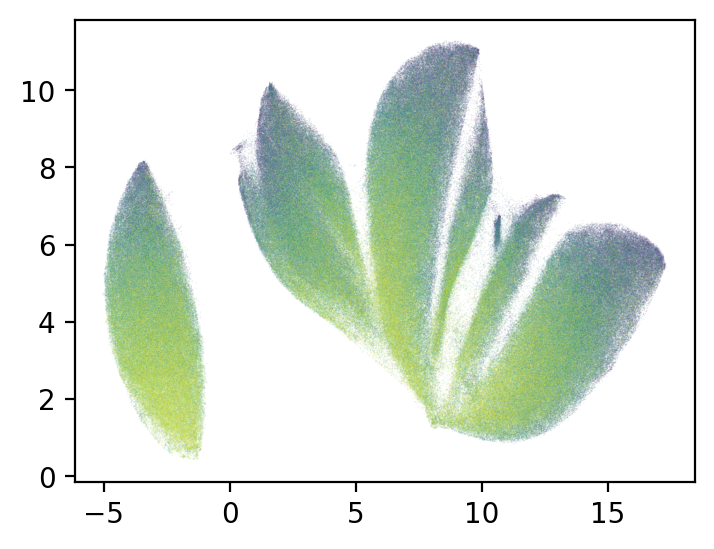

In [62]:
# Stack all latents and create labels
all_lats = np.vstack([lats[k] for k in sorted(lats.keys())])
labels = np.concatenate([[k]*len(lats[k]) for k in sorted(lats.keys())])


from matplotlib import pyplot as plt
# Create UMAP embedding
import umap
# load gpra embedding
embedding = np.load('../numerical_results/gpra_embedding.npy')
# reducer = umap.UMAP()
# can we fit on a subset and then use the same embedding for all?
# random 100k
# idx = np.random.permutation(len(all_lats))[:100_000]
# embedding = reducer.fit_transform(all_lats) #[idx])
# embedding = reducer.transform(all_lats) # [idx])
# save embedding to numerical results
# np.save('../numerical_results/gpra_embedding.npy', embedding)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

norm = Normalize(vmin=labels.min(), vmax=labels.max())
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

# scatter with explicit ax
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=labels,
    palette=cmap,
    hue_norm=norm,
    s=.2,
    alpha=0.1,
    legend=False,
    ax=ax
)

# Add set latents to the plot
set_lats = np.vstack([lats[k].mean(axis=0, keepdims=True) for k in sorted(lats.keys())])
set_embedding = reducer.transform(set_lats)

# Plot set latents with no alpha
sns.scatterplot(
    x=set_embedding[:, 0], 
    y=set_embedding[:, 1],
    hue=sorted(lats.keys()),
    palette=cmap,
    hue_norm=norm,
    s=100,
    alpha=1.0,
    legend=False,
    ax=ax,
    marker='*'
)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# make the ScalarMappable manually
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# pass ax to colorbar so it knows where to go :)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Expression Quantile")

plt.show()


In [ ]:
# Stack all latents and create labels
all_lats = np.vstack([lats[k] for k in sorted(lats.keys())])
labels = np.concatenate([[k]*len(lats[k]) for k in sorted(lats.keys())])


from matplotlib import pyplot as plt
# Create UMAP embedding
import umap
# reducer = umap.UMAP()
# can we fit on a subset and then use the same embedding for all?
# random 100k
# idx = np.random.permutation(len(all_lats))[:100_000]
# embedding = reducer.fit_transform(all_lats) #[idx])
# embedding = reducer.transform(all_lats) # [idx])
# save embedding to numerical results
# np.save('../numerical_results/gpra_embedding.npy', embedding)

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

norm = Normalize(vmin=labels.min(), vmax=labels.max())
cmap = plt.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

# scatter with explicit ax
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=labels,
    palette=cmap,
    hue_norm=norm,
    s=.2,
    alpha=0.1,
    legend=False,
    ax=ax
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# make the ScalarMappable manually
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# pass ax to colorbar so it knows where to go :)
cbar = plt.colorbar(sm, ax=ax)=
cbar.set_label("Expression Quantile")

plt.show()


In [14]:
with torch.no_grad():
    set_lats = {k: enc(enc_seqs[k][:100_000].to('cuda').unsqueeze(0)).cpu().numpy() for k in enc_seqs}

In [243]:
# concat set_lats into a single array
with torch.no_grad():
    all_lats = np.vstack([set_lats[k] for k in sorted(set_lats.keys())])
    all_lats_ = np.repeat(all_lats, 100, axis=0)
    rec = gen.sample(torch.from_numpy(all_lats_).to('cuda'), num_samples=100)
# rec = rec.reshape(98, 100 * 100, 129)

In [15]:
# load rec from numerical results
rec = np.load('../numerical_results/rec.npy')
rec = rec.reshape(98, 100 * 100, 129)

In [244]:
# save rec
# np.save('rec.npy', rec.cpu().numpy())

In [16]:
# convert tokenized to onehot efficiently
actgn = torch.eye(5)

def roll_rows(x: torch.Tensor, shifts: torch.Tensor) -> torch.Tensor:
    """
    Roll each row of x by the amount specified in shifts.
    
    Args:
        x (Tensor): 2D tensor of shape (n_rows, n_cols)
        shifts (Tensor): 1D tensor of shape (n_rows,) with integer shifts per row

    Returns:
        Tensor: Rolled version of x
    """
    n_rows, n_cols = x.shape
    # Create a base index tensor
    idx = torch.arange(n_cols, device=x.device).expand(n_rows, -1)
    # Shift indices with broadcasting
    shifted_idx = (idx - shifts[:, None]) % n_cols
    return x.gather(1, shifted_idx)


def tokenized_to_onehot(tok):
    tok = tok.flip(1)
    num_pad = (tok == 1).sum(dim=1)
    tok = tok - 5
    tok = roll_rows(tok, -num_pad)
    tok[tok < 0] = 4
    tok_oh = actgn[tok]
    return tok_oh


In [17]:
rec = torch.from_numpy(rec)

In [18]:
rec.shape

torch.Size([98, 10000, 129])

In [19]:
rec_oh = tokenized_to_onehot(rec.reshape(-1, 129).cpu()).reshape(rec.shape[0], -1, 129, 5)

In [ ]:
from tqdm import tqdm
ori_scores = {}
for k in tqdm(range(2, 98)):
    batch_scores, valid = torch_batch_scan(oh_seqs[k][:10000].float(), pwm_arr) #.mean(axis=0).mean(axis=0).numpy()
    batch_scores[~valid] = 0.0
    batch_scores = batch_scores.numpy()
    break
    ori_scores[k] = (batch_scores >= 5.0).sum(axis=1).mean(axis=0)

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:01<?, ?it/s]


In [21]:
from tqdm import tqdm
rec_scores = {}
for k in tqdm(range(2, 98)):
    batch_scores, valid = torch_batch_scan(rec_oh[k-2][..., :4].float(), pwm_arr) #.mean(axis=0).mean(axis=0).numpy()
    batch_scores[~valid] = 0.0
    batch_scores = batch_scores.numpy()
    rec_scores[k] = (batch_scores >= 5.0).sum(axis=1).mean(axis=0)

100%|██████████| 96/96 [05:05<00:00,  3.18s/it]


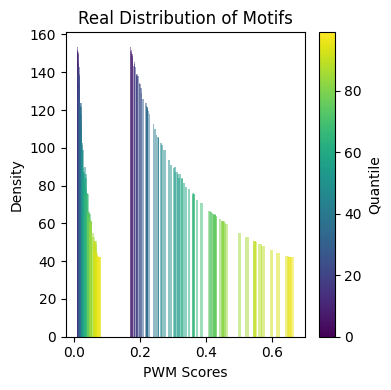

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)  # Add axes explicitly

# Get colormap for 100 quantiles
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=99)  # 100 quantiles from 0-99

# Plot histogram for each quantile with alpha based on quantile number
for k in sorted(ori_scores.keys()):
    color = cmap(norm(k))
    ax.hist(ori_scores[k][ori_scores[k] > 0.0], bins=50, alpha=0.5, 
            color=color, density=True, label=None)

ax.set_xlabel('PWM Scores')
ax.set_ylabel('Density')
ax.set_title('Real Distribution of Motifs')

# Add colorbar - this is the fixed part
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line fixes the error
plt.colorbar(sm, ax=ax, label='Quantile')  # Provide the ax parameter

plt.tight_layout()
plt.show()


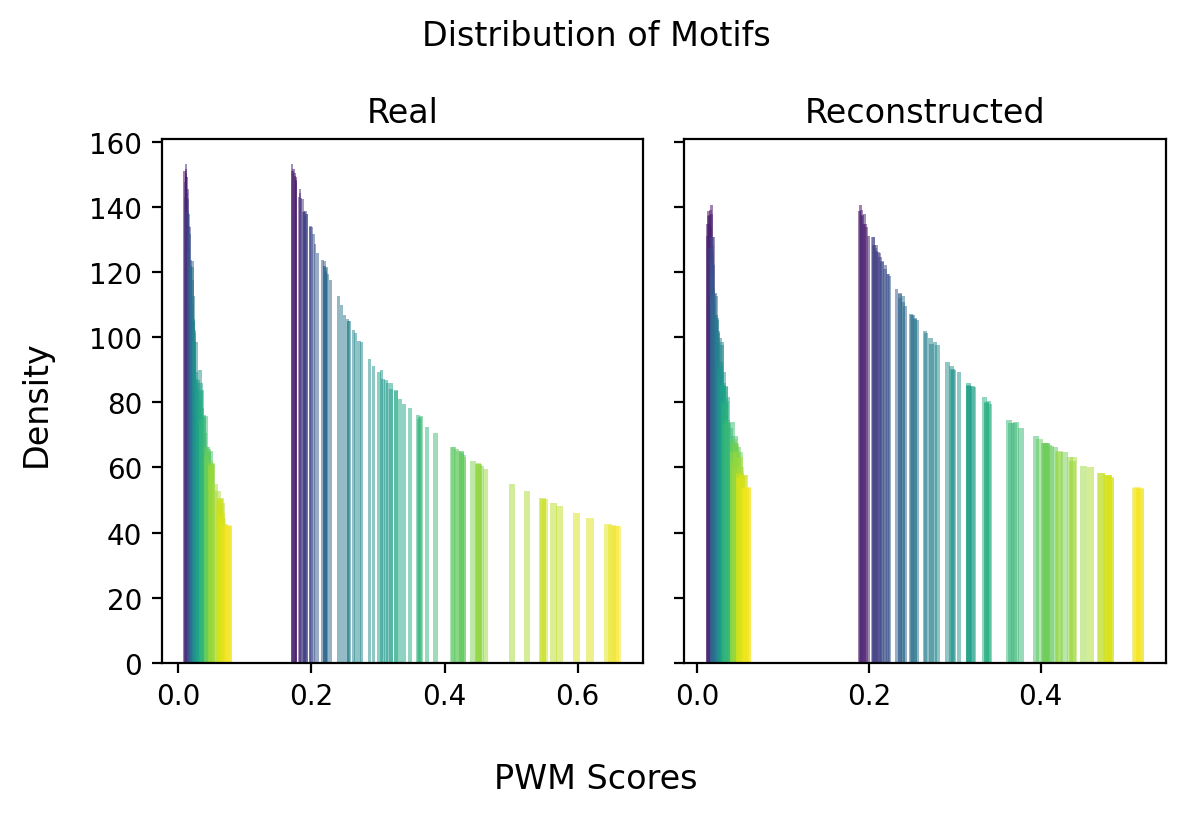

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
# shared y axis
fig = plt.figure(figsize=(6, 4), dpi=200)
axs = fig.subplots(1, 2, sharey=True)

# Get colormap for 100 quantiles
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=2, vmax=98)  # 100 quantiles from 0-99

# Plot histogram for each quantile with alpha based on quantile number
for k in sorted(rec_scores.keys()):
    color = cmap(norm(k))
    axs[1].hist(rec_scores[k][rec_scores[k] > 0.0], bins=50, alpha=0.5, 
            color=color, density=True, label=None)

axs[1].set_title('Reconstructed')

# Plot histogram for each quantile with alpha based on quantile number
for k in sorted(ori_scores.keys()):
    color = cmap(norm(k))
    axs[0].hist(ori_scores[k][ori_scores[k] > 0.0], bins=50, alpha=0.5, 
            color=color, density=True, label=None)

axs[0].set_title('Real')

fig.suptitle('Distribution of Motifs')

# set shared y label
fig.supylabel('Density')
# set shared x label on fig
fig.supxlabel('PWM Scores')

# Add colorbar - this is the fixed part
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line fixes the error
plt.colorbar(sm, ax=ax, label='Quantile')  # Provide the ax parameter

plt.tight_layout()
plt.show()

{52: array([[ 0.02698708, -0.02234118, -0.02592996, -0.05361912,  0.0039199 ,
         -0.17663325,  0.0899086 , -0.06036528, -0.01653949, -0.01439367,
          0.06574858,  0.11100969,  0.03888708,  0.06943604, -0.06190301,
          0.09694859,  0.04549848,  0.00523163,  0.03684765, -0.02721904,
          0.00100685, -0.02416033,  0.09373458,  0.01392969, -0.03231046,
          0.00299039,  0.03122222, -0.14878516, -0.07493384,  0.01863262,
          0.0857613 ,  0.16795364, -0.01971118, -0.09644404, -0.02456825,
          0.10976336, -0.09239304, -0.04048423,  0.07990269, -0.03789001,
         -0.03262456,  0.02778291,  0.06843452,  0.0178615 , -0.09840235,
          0.13961904, -0.10199067, -0.00828086,  0.02920338,  0.20998716,
         -0.02266224, -0.11431432, -0.14298809, -0.08090369, -0.06039632,
          0.04274835, -0.00798234, -0.06104788,  0.04209589,  0.00701639,
         -0.01359569,  0.00819423, -0.08869943,  0.0019745 ]],
       dtype=float32),
 93: array([[-0.037806